<a href="https://colab.research.google.com/github/yishanhsieh/a30-spr2024/blob/main/lab13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="m01-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/yy/dviz-course/blob/master/docs/m13-text/lab13.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a href="https://yyahn.com/dviz-course/m13-text/lab13/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on Github</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/yy/dviz-course/master/docs/m13-text/lab13.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View raw on Github</a>
  </td>
</table>

# Module 13: Texts

We'll use `spaCy` and `wordcloud` to play with text data. `spaCy` is probably the best python package for analyzing text data. It's capable and super fast. Let's install them.

    pip install wordcloud spacy
    
To use spaCy, you also need to download models. Run:

    python -m spacy download en_core_web_sm
    

## SpaCy basics

In [ ]:
import spacy
import wordcloud

nlp = spacy.load('en_core_web_sm')

Usually the first step of text analysis is _tokenization_, which is the process of breaking a document into "tokens". You can roughly think of it as extracting each word.

In [ ]:
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')

for token in doc:
    print(token)

Apple
is
looking
at
buying
U.K.
startup
for
$
1
billion


As you can see, it's not exactly same as `doc.split()`. You'd want to have `$` as a separate token because it has a particular meaning (USD). Actually, as shown in an example (https://spacy.io/usage/spacy-101#annotations-pos-deps), `spaCy` figures out a lot of things about these tokens. For instance,

In [ ]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_)

Apple Apple PROPN NNP
is be AUX VBZ
looking look VERB VBG
at at ADP IN
buying buy VERB VBG
U.K. U.K. PROPN NNP
startup startup NOUN NN
for for ADP IN
$ $ SYM $
1 1 NUM CD
billion billion NUM CD


It figured it out that `Apple` is a proper noun ("PROPN" and "NNP"; see [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for the part of speech tags).

`spaCy` has a visualizer too.

In [ ]:
from spacy import displacy
displacy.render(doc, style='dep', jupyter=True, options={'distance': 100})

It even recognizes entities and can visualize them.

In [ ]:
text = """But Google is starting from behind. The company made a late push
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa
software, which runs on its Echo and Dot devices, have clear leads in
consumer adoption."""

doc2 = nlp(text)
displacy.render(doc2, style='ent', jupyter=True)

## Let's read a book

Shall we load some serious book? You can use any books that you can find as a text file.

In [ ]:
import urllib.request

book = urllib.request.urlopen('https://sherlock-holm.es/stories/plain-text/stud.txt').read()

In [ ]:
book[:1000]

b'\n\n\n\n                               A STUDY IN SCARLET\n\n                               Arthur Conan Doyle\n\n\n\n\n\n\n\n                                Table of contents\n\n         Part I\n        Mr. Sherlock Holmes\n        The Science Of Deduction\n        The Lauriston Garden Mystery\n        What John Rance Had To Tell\n        Our Advertisement Brings A Visitor\n        Tobias Gregson Shows What He Can Do\n        Light In The Darkness\n\n         Part II\n        On The Great Alkali Plain\n        The Flower Of Utah\n        John Ferrier Talks With The Prophet\n        A Flight For Life\n        The Avenging Angels\n        A Continuation Of The Reminiscences Of John Watson, M.D.\n        The Conclusion\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n                                      PART I\n\n                   (Being a reprint from the reminiscences of\n                              John H. Watson, M.D.,\n                      late of the Army Medical Department.)\n\n\n\n\

Looks like we have successfully loaded the book. You'd probably want to remove the parts at the beginning and at the end that are not parts of the book if you are doing a serious analysis, but let's ignore them for now. Let's try to feed this directly into `spaCy`.  

In [ ]:
doc = nlp(book)

ExtraData: unpack(b) received extra data.

## On encodings

What are we getting this error? What does it mean? It says `nlp` function expects `str` type but we passed `bytes`.

In [ ]:
type(book)

bytes

Indeed, the type of `metamorphosis_book` is `bytes`. But as we have seen above, we can see the book contents right? What's going on?

Well, the problem is that a byte sequence is not yet a proper string until we know how to decode it. A string is an abstract object and we need to specify an encoding to write the string into a file. For instance, if I have a string of Korean characters like "안녕", there are several encodings that I can specify to write that into a file, and depending on the encoding that I choose, the byte sequences can be totally different from each other. This is a really important (and confusing) topic, but because it's beyond the scope of the course, I'll just link a nice post about encoding: http://kunststube.net/encoding/

In [ ]:
"안녕".encode('utf8')

b'\xec\x95\x88\xeb\x85\x95'

In [ ]:
# b'\xec\x95\x88\xeb\x85\x95'.decode('euc-kr') <- what happen if you do this?
b'\xec\x95\x88\xeb\x85\x95'.decode('utf8')

'안녕'

In [ ]:
"안녕".encode('euc-kr')

b'\xbe\xc8\xb3\xe7'

In [ ]:
b'\xbe\xc8\xb3\xe7'.decode('euc-kr')

'안녕'

You can decode with "wrong" encoding too.

In [ ]:
b'\xbe\xc8\xb3\xe7'.decode('latin-1')

'¾È³ç'

As you can see the same string can be encoded into different byte sequences depending on the encoding. It's a really ~~annoying~~ fun topic and if you need to deal with text data, you must have a good understanding of it.

There is a lot of complexity in encoding. But for now, just remember that `utf-8` encoding is the most common encoding. It is also compatible with ASCII encoding as well. That means you can _decode_ both ASCII and utf-8 documents with utf-8 encoding. So let's decode the byte sequence into a string.

In [ ]:
# YOUR SOLUTION HERE

book_str = book.decode('utf-8')

In [ ]:
type(book_str)

str

Shall we try again?

In [ ]:
doc = nlp(book_str)

In [ ]:
words = [token.text for token in doc
         if token.is_stop != True and token.is_punct != True]

In [ ]:
words[:10]

['\n\n\n\n                               ',
 'STUDY',
 'SCARLET',
 '\n\n                               ',
 'Arthur',
 'Conan',
 'Doyle',
 '\n\n\n\n\n\n\n\n                                ',
 'Table',
 'contents']

## Let's count!

In [ ]:
from collections import Counter

Counter(words).most_common(5)

[('\n     ', 3107),
 ('\n\n     ', 772),
 ('said', 207),
 ('man', 155),
 ('Holmes', 98)]

a lot of newline characters and multiple spaces. A quick and dirty way to remove them is split & join. The idea is that you split the document using `split()` and then join with a single space ` `. Can you implement it and print the 10 most common words?

In [ ]:
# YOUR SOLUTION HERE
words = [" ".join(word.split()) for word in words if word.strip()]
word_frequency = Counter(words).most_common(10)
word_frequency

[('said', 207),
 ('man', 155),
 ('Holmes', 98),
 ('little', 80),
 ('time', 77),
 ('way', 69),
 ('came', 67),
 ('face', 67),
 ('asked', 65),
 ('come', 64)]

Let's keep the object with word count.

In [ ]:
word_cnt = Counter(words)

## Some wordclouds?

In [ ]:
import matplotlib.pyplot as plt

Can you check out the `wordcloud` package documentation and create a word cloud from the word count object that we created from the book above and plot it?

In [ ]:
# Implement: create a word cloud object

# YOUR SOLUTION HERE
from wordcloud import WordCloud
WordCloud()

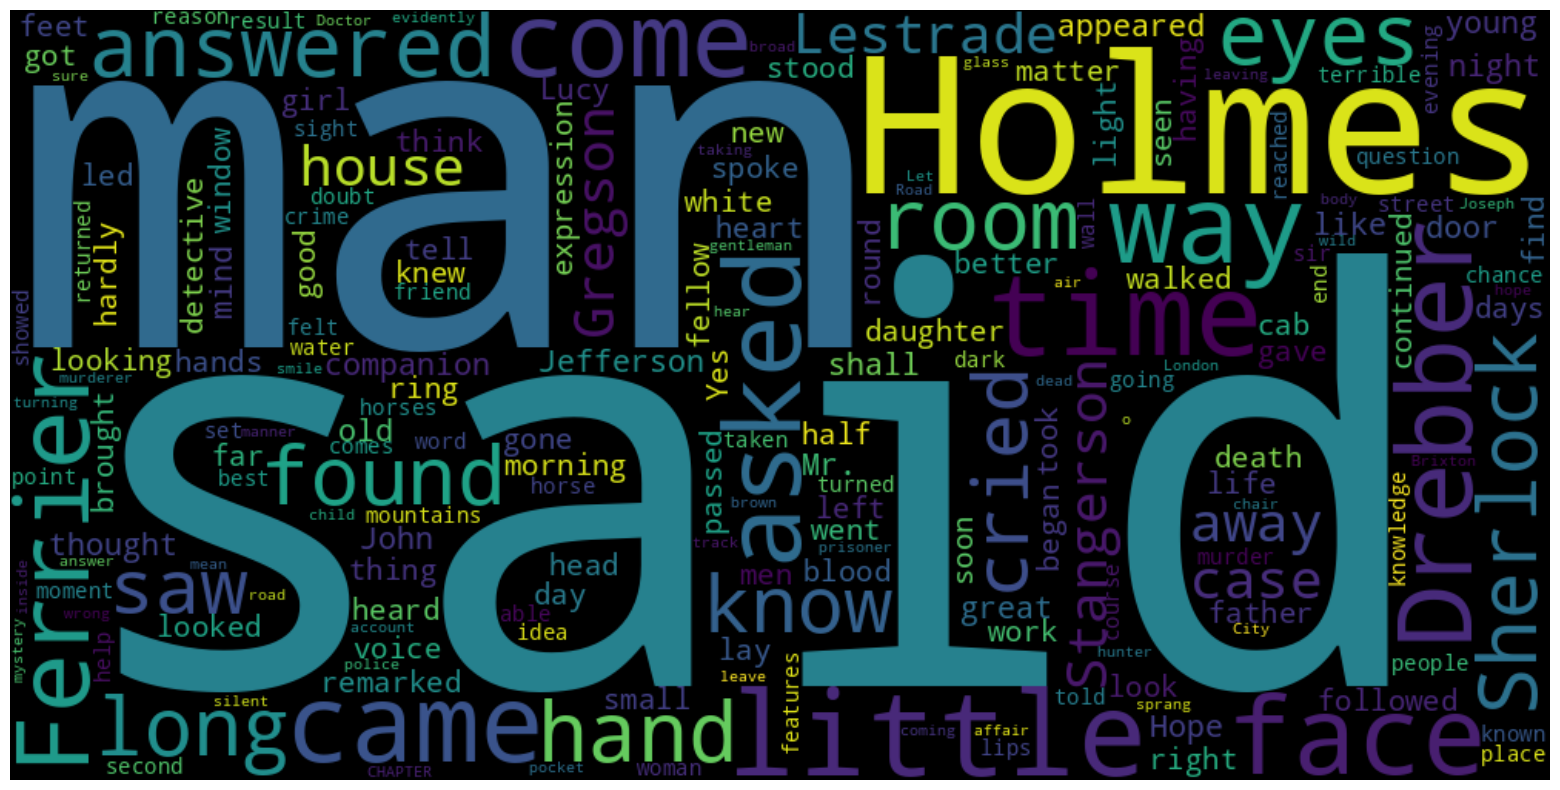

In [ ]:
# Implement: plot the word cloud object

# YOUR SOLUTION HERE

wordcloud = WordCloud(width = 1000, height=500).generate_from_frequencies(word_cnt)

plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Q: Can you create a word cloud for a certain part of speech, such as nouns, verbs, proper nouns, etc. (pick one)?**

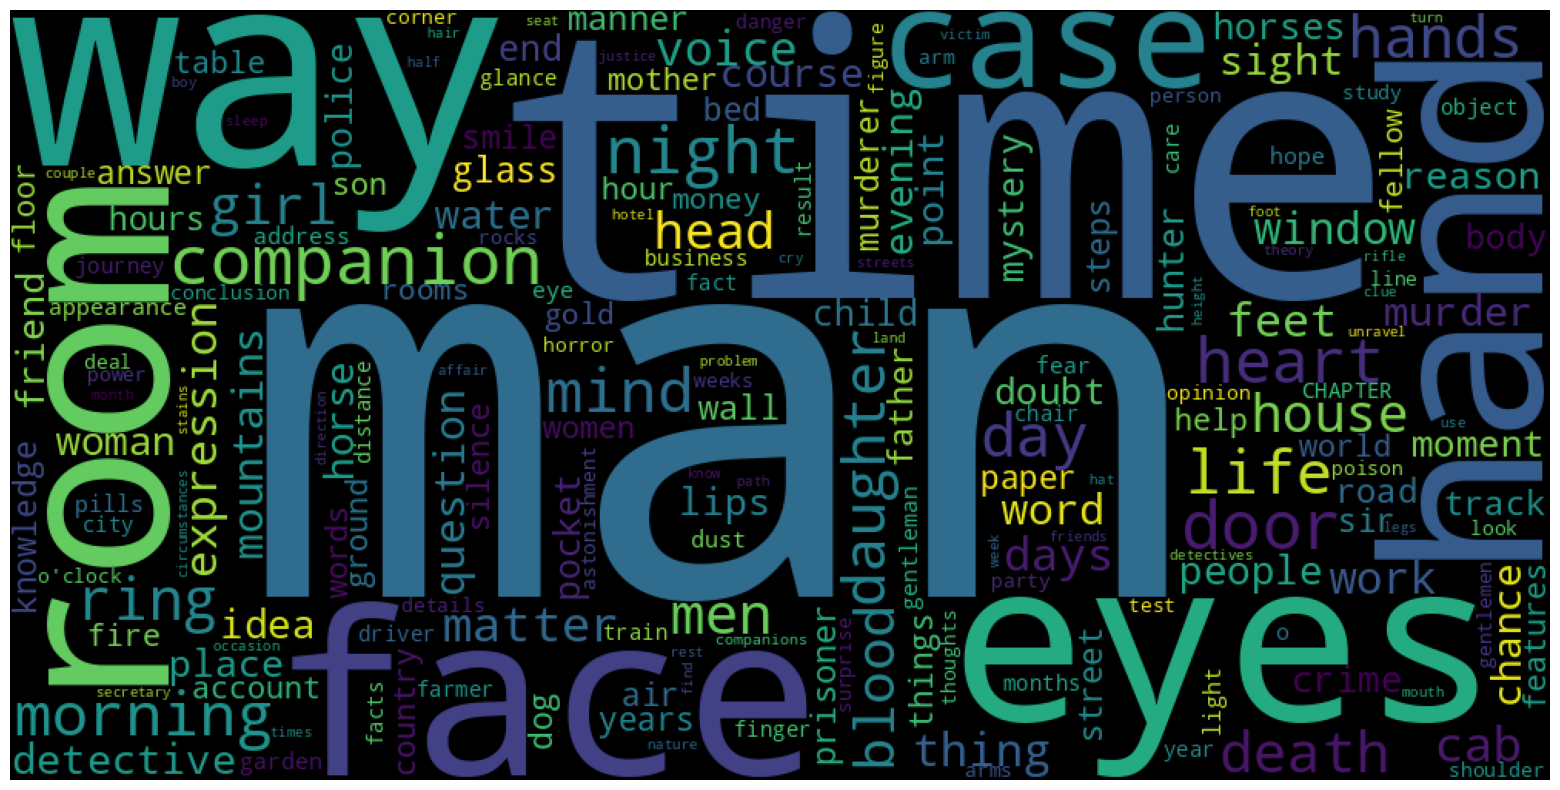

In [ ]:
# YOUR SOLUTION HERE
doc = nlp(" ".join(words))
nouns = [w.text for w in doc if w.pos_ == "NOUN"]
noun_cnt = Counter(nouns)
noun_wc = WordCloud(width=1000, height=500).generate_from_frequencies(noun_cnt)

plt.figure(figsize = (20,10))
plt.imshow(noun_wc)
plt.axis("off")
plt.show()


In [ ]:
doc

STUDY SCARLET Arthur Conan Doyle Table contents Mr. Sherlock Holmes Science Deduction Lauriston Garden Mystery John Rance Tell Advertisement Brings Visitor Tobias Gregson Shows Light Darkness II Great Alkali Plain Flower Utah John Ferrier Talks Prophet Flight Life Avenging Angels Continuation Reminiscences John Watson M.D. Conclusion reprint reminiscences John H. Watson M.D. late Army Medical Department CHAPTER Mr. Sherlock Holmes year 1878 took degree Doctor Medicine University London proceeded Netley course prescribed surgeons army Having completed studies duly attached Fifth Northumberland Fusiliers Assistant Surgeon regiment stationed India time join second Afghan war broken landing Bombay learned corps advanced passes deep enemy country followed officers situation succeeded reaching Candahar safety found regiment entered new duties campaign brought honours promotion misfortune disaster removed brigade attached Berkshires served fatal battle Maiwand struck shoulder Jezail bullet sh

## Topic modeling

Another basic text analysis is _topic modeling_. Imagine you have a bunch of documents and you want to know what are the main topics that are discussed in these documents. Topic modeling methods aim to extract these "topics" automatically based on the words that appear in the documents. In topic modeling, each topic can be thought of as a distribution over words. For instance, a topic can be "politics" and it can be represented as a probability distribution over words like "election", "vote", "president", etc.

Let's do a simple topic modeling with `bertopic` package. Although there is a long history of topic modeling, with many methods such as LDA, just like many other NLP tasks, topic modeling is also being replaced by LLM-based methods like BERTopic, so we'd like to try that as well. You should already have `scikit-learn` installed. Let's install `bertopic`.

```
pip install bertopic
```

Let's first get the dataset included in scikit-learn.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

newsgroup_data = fetch_20newsgroups(subset='all')

We can inspect what's inside. Feel free to play with it.

In [ ]:
newsgroup_data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [ ]:
len(newsgroup_data.filenames)

18846

In [ ]:
print(newsgroup_data.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1

You can look into the data as well.

In [ ]:
print(newsgroup_data.data[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




You can load a more "clean" data like following.

In [ ]:
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [ ]:
print(docs[0])



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




BERTopic follows the convention of the scikit-learn API. You can fit the model with `fit_transform` method.

In [ ]:
%%capture
!pip install bertopic

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

The package also has a quick visualizer, where you can see the topics and the words that are associated with the topics.

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_topics()

Another visualization we can do (see https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-documents) is to use the sentence embedding model to embed the documents into a vector space and visualize all the documents using the UMAP algorithm, along with the topics.

This time, I'll set the `min_topic_size` to 100 to reduce the number of topics it finds and to make the visualization simpler.

In [ ]:
from sentence_transformers import SentenceTransformer
from umap import UMAP

# Prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

topic_model = BERTopic(min_topic_size=100).fit(docs, embeddings)

# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)


KeyboardInterrupt: 

**Q: Can you identify an interesting dataset of documents and apply BERTopic & produce the visualization?**